# Lab 8: Sampling with Metropolis–Hastings on the Ising Model

### Lab Date: Wednesday, Apr 2

### Lab Due: Wednesday, Apr 16

## Instructions

Work with your lab group to complete the following notebook. Your work will be reviewed by your peers in two weeks (Wednesday, April 16)

In this lab, you will:
1. Implement the Metropolis–Hastings algorithm for the 2D Ising model.
2. Compare different proposal distributions (independent spin flips vs. block updates) and understand their impact on convergence.
3. Test for the end of the burn-in period using visual diagnostics (and an automated running-average method).
4. Analyze mixing times by varying the grid size (especially near the critical temperature).

If you are new to working in python, or in a Jupyter notebook, please ask your lab members for help. If you notice a lab member struggling, and have experience, please offer your help.

Please see this [Ed post](https://edstem.org/us/courses/74615/discussion/6352659) for corrections, questions, and discussion. If you would rather work with your own copy of the files, I have uploaded a zip folder there with the lab materials. 

Corrections to the lab will be pushed directly to this notebook. We will only push corrections to the text, which is set to read only to prevent merge conflicts. In the event of a merge conflict, save your notebook under a different name, and click the link that launches the lab from the schedule on the [stat238 homepage](https://stat238.berkeley.edu/spring-2025/) again. Then, check for discrepancies. If you can't find them, or resolve the conflict, contact us.

## Set Up

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(123)

## Initialize the Ising Grid

Create a function initialize_grid(N) to generate an $N \times N$ grid where each site is randomly assigned a spin $+1$ or $-1$. This produces an initial state $\mathbf{s}_0$ by sampling each spin uniformly from $\{+1, -1\}$.

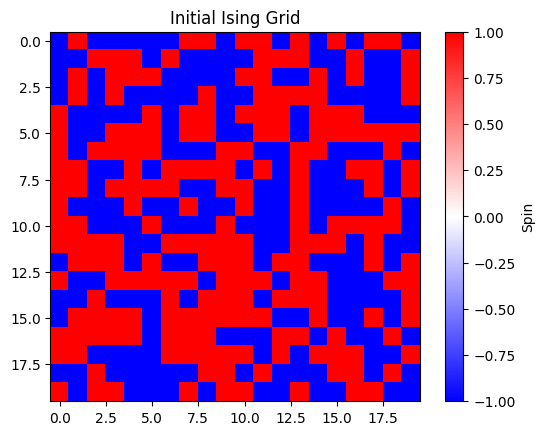

In [2]:
def initialize_grid(N):
    """
    Initialize an N x N grid with spins randomly set to +1 or -1.
    
    Each spin s_i is sampled independently from {+1, -1}.
    """
    return np.random.choice([-1, 1], size=(N, N))

# Example: Initialize a 20x20 grid and display it.
N = 20
grid = initialize_grid(N)
plt.imshow(grid, cmap="bwr")
plt.title("Initial Ising Grid")
plt.colorbar(label="Spin")
plt.show()

## Compute the Energy

Implement compute_energy(grid, J=1) to calculate the energy using the Ising Hamiltonian with periodic boundary conditions. The energy is given by
$$H(\mathbf{s}) = -J \sum_{\langle i,j \rangle} s_i s_j,$$
where the summation is over all nearest-neighbor pairs and we divide by 2 to avoid double counting. Periodic boundaries ensure neighbors “wrap around.”

In [3]:
def compute_energy(grid, J=1):
    """
    Compute the energy of the grid using the Ising Hamiltonian with periodic boundaries.
    
    Mathematical Formulation:
      H(s) = -J * sum_{<i,j>} s_i * s_j,
    with each nearest-neighbor pair counted twice.
    """
    N = grid.shape[0]
    energy = 0
    for i in range(N):
        for j in range(N):
            s = grid[i, j]
            # Nearest neighbors with periodic boundary conditions.
            neighbors = (grid[(i+1) % N, j] +
                         grid[(i-1) % N, j] +
                         grid[i, (j+1) % N] +
                         grid[i, (j-1) % N])
            energy += -J * s * neighbors
    return energy / 2  # Correct for double counting

# Example: Compute and display the energy of the initial grid.
energy0 = compute_energy(grid)
print("Initial Energy:", energy0)

Initial Energy: 0.0


## Proposal: Independent Spin Flips

Implement proposal_independent(grid, flip_prob) to update each spin independently by flipping it with probability $p = \text{flip_prob}$. This update represents a local change, where each spin’s new value is given by:
$$s_i \rightarrow -s_i \quad \text{with probability } p.$$
Because the proposal is symmetric, the MH acceptance probability depends only on the energy difference.

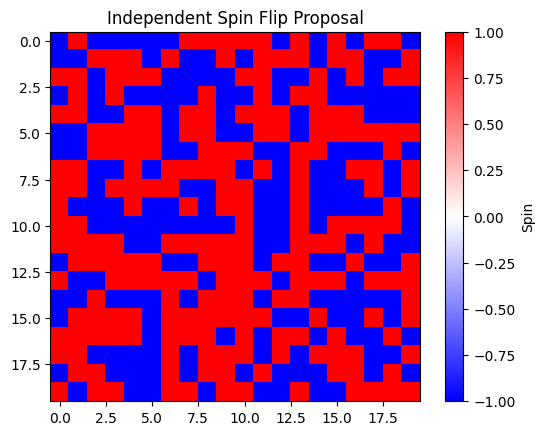

In [4]:
def proposal_independent(grid, flip_prob):
    """
    For each spin in the grid, flip its sign with probability flip_prob.
    
    This implements a local update with a symmetric proposal.
    """
    new_grid = grid.copy()
    N = grid.shape[0]
    for i in range(N):
        for j in range(N):
            if np.random.rand() < flip_prob:
                new_grid[i, j] = -new_grid[i, j]
    return new_grid

# Example: Apply the independent spin flip proposal with a 5% flip probability.
flip_prob = 0.05
grid_proposed = proposal_independent(grid, flip_prob)
plt.imshow(grid_proposed, cmap="bwr")
plt.title("Independent Spin Flip Proposal")
plt.colorbar(label="Spin")
plt.show()

## Proposal: Block Updates

Implement proposal_block_update(grid, block_size, update_fraction) to partition the grid into $k \times k$ blocks and randomly scramble the spins in a fraction $p = \text{update_fraction}$ of these blocks.
Mathematical Formulation:
The grid is divided into blocks. If there are $M$ blocks, then approximately $p \times M$ blocks are chosen for update. Within each chosen block, the spins are randomly permuted (uniformly over all possible arrangements), ensuring a symmetric proposal.

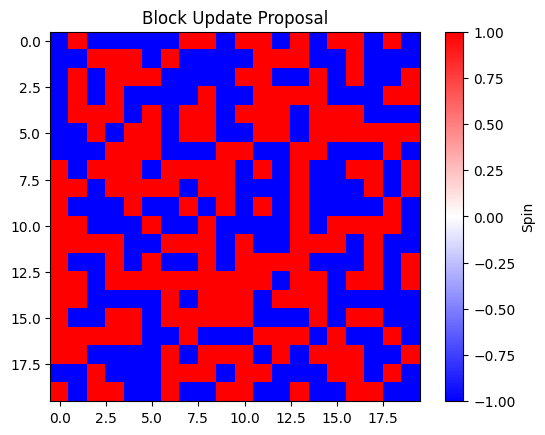

In [5]:
def proposal_block_update(grid, block_size, update_fraction):
    """
    Partition the grid into blocks of size block_size x block_size.
    Randomly select a fraction update_fraction of blocks and scramble their spins.
    
    Assumption: Grid size N is divisible by block_size.
    """
    N = grid.shape[0]
    new_grid = grid.copy()
    num_blocks = N // block_size  # number of blocks per dimension
    total_blocks = num_blocks * num_blocks
    num_to_update = int(np.ceil(update_fraction * total_blocks))
    
    # List of block indices.
    blocks = [(i, j) for i in range(num_blocks) for j in range(num_blocks)]
    selected_indices = np.random.choice(len(blocks), size=num_to_update, replace=False)
    
    for idx in selected_indices:
        block_i, block_j = blocks[idx]
        start_i = block_i * block_size
        start_j = block_j * block_size
        block = new_grid[start_i:start_i + block_size, start_j:start_j + block_size]
        block_flat = block.flatten()
        np.random.shuffle(block_flat)
        new_grid[start_i:start_i + block_size, start_j:start_j + block_size] = block_flat.reshape(block_size, block_size)
    
    return new_grid

# Example: Apply block update with block size 4 and 30% of blocks updated.
block_size = 4
update_fraction = 0.3
grid_proposed_block = proposal_block_update(grid, block_size, update_fraction)
plt.imshow(grid_proposed_block, cmap="bwr")
plt.title("Block Update Proposal")
plt.colorbar(label="Spin")
plt.show()

## Metropolis–Hastings Update Step

Implement metropolis_hastings_step(grid, proposal_func, temperature, **proposal_kwargs) that carries out one MH update. It should calculate the energy $H(\mathbf{s})$ of the current state, propose a new state $\mathbf{s}^{\prime}$, compute $\Delta H = H(\mathbf{s}^{\prime}) - H(\mathbf{s})$, and accept $\mathbf{s}^{\prime}$ with probability
$$\alpha(\mathbf{s}, \mathbf{s}^{\prime}) = \min\left(1, \exp\left(-\frac{\Delta H}{T}\right)\right).$$ This acceptance probability ensures detailed balance and drives the chain towards the equilibrium distribution.

In [6]:
def metropolis_hastings_step(grid, proposal_func, temperature, **proposal_kwargs):
    """
    Perform one Metropolis–Hastings update step.
    
    Steps:
      1. Compute current energy H(s).
      2. Generate proposed state s' using proposal_func.
      3. Compute ΔH = H(s') - H(s).
      4. Accept s' with probability: min(1, exp(-ΔH/T)).
    
    Returns:
      new_grid: the updated configuration.
      accepted: True if the move is accepted; otherwise, False.
    """
    current_energy = compute_energy(grid)
    proposed_grid = proposal_func(grid, **proposal_kwargs)
    proposed_energy = compute_energy(proposed_grid)
    delta_E = proposed_energy - current_energy
    
    if delta_E < 0 or np.random.rand() < np.exp(-delta_E / temperature):
        return proposed_grid, True
    else:
        return grid, False

# Test one MH step using the independent proposal.
temperature = 2/(np.log(1+np.sqrt(2)))
grid, accepted = metropolis_hastings_step(grid, proposal_independent, temperature, flip_prob=flip_prob)
print("MH Step accepted?", accepted)

MH Step accepted? True


## Run the Simulation

Implement run_simulation(initial_grid, proposal_func, temperature, n_steps, **proposal_kwargs) to run the MH algorithm for a fixed number of iterations. Record both the energy and the magnetization at each step.

The magnetization is defined as
$$M = \frac{1}{N^2} \sum_{i} s_i.$$
Tracking $H(\mathbf{s})$ and $M$ over iterations helps you monitor convergence.

In [7]:
def run_simulation(initial_grid, proposal_func, temperature, n_steps, **proposal_kwargs):
    """
    Run the MH simulation for n_steps iterations.
    
    Records:
      - Energy: H(s)
      - Magnetization: M = (1/N^2) * sum(s)
    
    Returns:
      grid: Final configuration.
      energies: Array of energy values over iterations.
      magnetizations: Array of magnetization values over iterations.
    """
    grid = initial_grid.copy()
    energies = []
    magnetizations = []
    
    for step in range(n_steps):
        grid, _ = metropolis_hastings_step(grid, proposal_func, temperature, **proposal_kwargs)
        energies.append(compute_energy(grid))
        magnetizations.append(np.mean(grid))
    
    return grid, np.array(energies), np.array(magnetizations)

# Example: Run simulation with the independent spin flip proposal.
n_steps = 10000
# Independent Spin Flips Simulation
grid0_indep = initialize_grid(N)
grid_final_indep, energies_indep, magnetizations_indep = run_simulation(
    grid0_indep, proposal_independent, temperature, n_steps, flip_prob=flip_prob
)

# Block Updates Simulation
grid0_block = initialize_grid(N)
grid_final_block, energies_block, magnetizations_block = run_simulation(
    grid0_block, proposal_block_update, temperature, n_steps, block_size=block_size, update_fraction=update_fraction
)

## Visual Diagnostics and Burn-In Detection

Plot energy and magnetization versus iteration to visually assess convergence. Then, implement an automated method to detect the burn-in period using a running average comparison. The burn-in period is identified as the earliest iteration at which the running average over a fixed window is within a specified threshold of the final average.

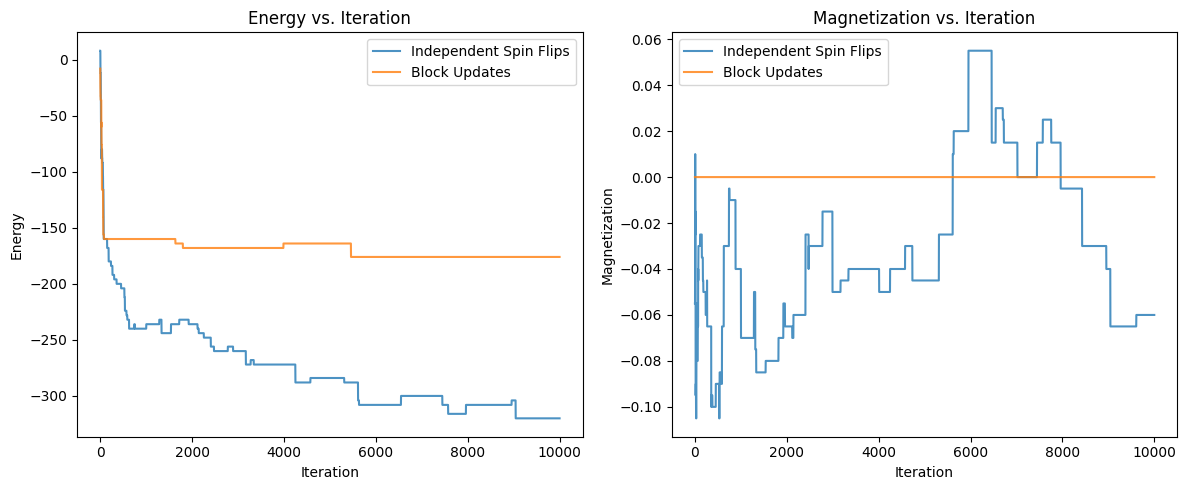

In [8]:
plt.figure(figsize=(12,5))

# Plot energy for both proposals.
plt.subplot(1,2,1)
plt.plot(energies_indep, label="Independent Spin Flips", alpha=0.8)
plt.plot(energies_block, label="Block Updates", alpha=0.8)
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("Energy vs. Iteration")
plt.legend()

# Plot magnetization for both proposals.
plt.subplot(1,2,2)
plt.plot(magnetizations_indep, label="Independent Spin Flips", alpha=0.8)
plt.plot(magnetizations_block, label="Block Updates", alpha=0.8)
plt.xlabel("Iteration")
plt.ylabel("Magnetization")
plt.title("Magnetization vs. Iteration")
plt.legend()

plt.tight_layout()
plt.show()

Independent Spin Flips: Estimated burn-in (energy) ends at iteration: 9032
Block Updates: Estimated burn-in (energy) ends at iteration: 5450


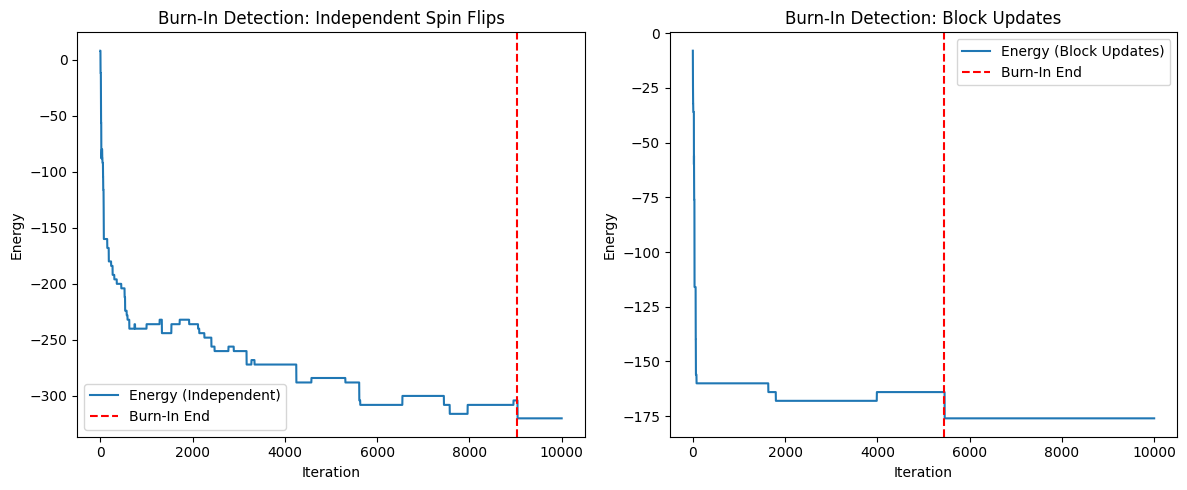

In [9]:
def detect_burn_in_energy(energy_series, threshold=0.01, window=50):
    """
    Estimate the burn-in period using energy as the observable.
    
    Parameters:
      energy_series : 1D numpy array of energy values.
      threshold     : Relative difference threshold (default: 0.01).
      window        : Window size for computing the running average (default: 100 iterations).
    
    Returns:
      The estimated burn-in iteration.
    """
    final_avg = np.mean(energy_series[-window:])
    for i in range(len(energy_series) - window):
        running_avg = np.mean(energy_series[i:i+window])
        if np.abs(running_avg - final_avg) < threshold * np.abs(final_avg):
            return i
    return len(energy_series)

# Detect burn-in for both proposals.
burn_in_energy_indep = detect_burn_in_energy(energies_indep, threshold=0.01, window=50)
burn_in_energy_block = detect_burn_in_energy(energies_block, threshold=0.01, window=50)

print("Independent Spin Flips: Estimated burn-in (energy) ends at iteration:", burn_in_energy_indep)
print("Block Updates: Estimated burn-in (energy) ends at iteration:", burn_in_energy_block)

# Plot energy with burn-in detection for Independent Spin Flips.
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(energies_indep, label="Energy (Independent)")
plt.axvline(burn_in_energy_indep, color='red', linestyle='--', label="Burn-In End")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("Burn-In Detection: Independent Spin Flips")
plt.legend()

# Plot energy with burn-in detection for Block Updates.
plt.subplot(1,2,2)
plt.plot(energies_block, label="Energy (Block Updates)")
plt.axvline(burn_in_energy_block, color='red', linestyle='--', label="Burn-In End")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("Burn-In Detection: Block Updates")
plt.legend()

plt.tight_layout()
plt.show()

## Analyze Mixing Time vs. Grid Size

Vary the grid size and, for each size, run the simulation to estimate the burn-in period as a proxy for the mixing time.

Mixing time is expected to increase near the critical temperature. Plotting the burn-in (mixing time) versus grid size shows how convergence slows for larger systems.

Grid 5x5: Burn-in detected at iteration 1220
Grid 10x10: Burn-in detected at iteration 3782
Grid 15x15: Burn-in detected at iteration 9505
Grid 20x20: Burn-in detected at iteration 3361
Grid 25x25: Burn-in detected at iteration 8652
Grid 30x30: Burn-in detected at iteration 6657
Grid 5x5: Burn-in detected at iteration 0
Grid 10x10: Burn-in detected at iteration 124
Grid 15x15: Burn-in detected at iteration 470
Grid 20x20: Burn-in detected at iteration 7886
Grid 25x25: Burn-in detected at iteration 4714
Grid 30x30: Burn-in detected at iteration 3789


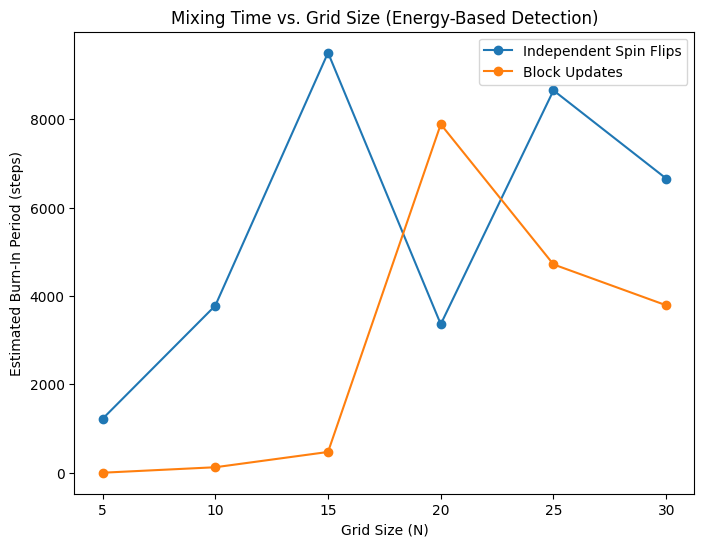

In [10]:
def analyze_mixing_time_energy(grid_sizes, proposal_func, temperature, n_steps, **proposal_kwargs):
    """
    For each grid size, run the simulation and estimate the burn-in period using the energy time series.
    
    Returns:
      A list of estimated burn-in periods (in steps) for the provided grid sizes.
    """
    burn_in_periods = []
    for N in grid_sizes:
        grid0 = initialize_grid(N)
        # Run simulation and record energies.
        _, energies, _ = run_simulation(grid0, proposal_func, temperature, n_steps, **proposal_kwargs)
        # Detect burn-in using the energy time series.
        burn_in = detect_burn_in_energy(energies, threshold=0.01, window=50)
        burn_in_periods.append(burn_in)
        print(f"Grid {N}x{N}: Burn-in detected at iteration {burn_in}")
    return burn_in_periods

# Define grid sizes for analysis.
grid_sizes = [5, 10, 15, 20, 25, 30]

# Analyze mixing time using Independent Spin Flips.
burn_in_periods_indep_energy = analyze_mixing_time_energy(
    grid_sizes, proposal_independent, temperature, n_steps, flip_prob=flip_prob
)

# Analyze mixing time using Block Updates.
burn_in_periods_block_energy = analyze_mixing_time_energy(
    grid_sizes, proposal_block_update, temperature, n_steps, block_size=block_size, update_fraction=update_fraction
)

# Plot the estimated burn-in periods vs. grid size for both proposals.
plt.figure(figsize=(8,6))
plt.plot(grid_sizes, burn_in_periods_indep_energy, marker='o', label="Independent Spin Flips")
plt.plot(grid_sizes, burn_in_periods_block_energy, marker='o', label="Block Updates")
plt.xlabel("Grid Size (N)")
plt.ylabel("Estimated Burn-In Period (steps)")
plt.title("Mixing Time vs. Grid Size (Energy-Based Detection)")
plt.legend()
plt.show()